# Using ModelKits with Jupyter Notebooks

### This project introduces the process of incorporating ModelKits into Jupyter Notebook workflows...(more text to come)

## Before You Begin
1. If you haven't aready done so, [sign up for a free account with Jozu.ml](https://api.jozu.ml/signup)
2. After you log into Jozu, add a new Repository named "titanic-survivability", which we'll use in this Notebook.
3. In the same directory as this Notebook--which we'll call the *Project directory*--create a `.env` file.
4. Edit the `.env` file and add an entry for your **JOZU_USERNAME**, your **JOZU_PASSWORD** and your **JOZU_NAMESPACE** (aka your **Personal Organization** name). For example:
```bash
     JOZU_USERNAME=brett@jozu.org
     JOZU_PASSWORD=my_password
     JOZU_NAMESPACE=brett
```
5. Be sure to save the changes to your .env file before continuing.


## General Housekeeping

This project requires Python 3.10 or above:

In [86]:
import sys

assert sys.version_info >= (3, 10)

Load the required python packages into your Notebook's environment using the following command:

```bash
    pip install -r requirements.txt
```

Let's define the default font sizes to make the figures prettier:

In [88]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Project Configuration

#### Define Project Constants

In [120]:
from pathlib import Path
from dotenv import load_dotenv
import os

# the name and path to the directory containing the project's data files
DATA_DIR_NAME = 'data'
DATA_PATH = Path() / DATA_DIR_NAME

# the name and path to the directory to where the model will be exported
MODEL_DIR_NAME = 'model'
MODEL_PATH = Path() / MODEL_DIR_NAME

# the name and path to the directory where any charts and/or graphs are exported as image files
IMAGES_DIR_NAME = 'images'
IMAGES_PATH = Path() / IMAGES_DIR_NAME

# the login credentials to Jozu.ml taken from environment variables stored in the .env file
load_dotenv(override=True)
JOZU_USER = os.getenv("JOZU_USERNAME")
JOZU_PWD = os.getenv("JOZU_PASSWORD")
JOZU_REGISTRY = "jozu.ml"
JOZU_NAMESPACE = os.getenv("JOZU_NAMESPACE")
JOZU_REPOSITORY = "titanic-survivability"

JOZU_REPOSITORY_PATH = JOZU_REGISTRY + "/" + JOZU_NAMESPACE + "/" + JOZU_REPOSITORY

#### Define Project Helper Functions

##### Define the `save_fig()` function which is used through this notebook to save the figures as image files.

In [90]:
from pathlib import Path

IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

##### Define the `print_directory_tree()` function which is used later to explore the project's directory structure.

Before we go continue, let's familiarize ourselves with the project's directory structure in detail by examining the output after running the next code cell:

In [91]:
def print_directory_tree(root, prefix=""):
    # Get a list of all files and directories in the current directory
    items = [item for item in root.iterdir() if not item.name.startswith('.')]
    
    # Sort the items to ensure directories come first
    #items.sort(key=lambda x: (x.is_file()))
    
    for index, item in enumerate(items):
        #path = os.path.join(root, item)
        path = item
        # Check if the current item is the last one in the list
        is_last = index == len(items) - 1
        
        # Print the current item
        print(prefix + ("└── " if is_last else "├── ") + item.name)
        
        # If the current item is a directory, recursively print its contents
        if path.is_dir():
            new_prefix = prefix + ("    " if is_last else "│   ")
            print_directory_tree(path, new_prefix)

print_directory_tree(Path())

├── requirements.txt
├── images
│   └── random_forest_vs_svm_accuracy_box_plot.png
├── README.md
├── titanic_survivability.ipynb
├── model
│   └── model.joblib
├── Kitfile
└── data
    ├── test.csv
    └── train.csv


At the heart of every [ModelKit](https://kitops.ml/docs/modelkit/intro.html) is a [Kitfile](https://kitops.ml/docs/kitfile/format.html), a YAML-formatted configuration file.

The Kitfile for this project has already been created and populated with the configuration details necessary to create a basic ModelKit, but we'll update it with additional information as necessary.

For now, let's execute the next code cell to view the Kitfile's contents:

##### Define Helper Functions for working with the Kitfile

In [92]:
import yaml

# Helper function to read the project's Kitfile from disk into
# a python dictionary object
def import_kitfile() -> dict:
    # Open the Kitfile 
    with open('Kitfile', 'r') as file:
        # Load the contents into a Python dictionary
        kitfile = yaml.safe_load(file)
    return kitfile

# Helper function to print the contents of the python dictionary object
# representing the project's Kitfile
def print_kitfile_contents(kitfile):
    print('Kitfile Contents...')
    print('===================\n')
    print(yaml.safe_dump(kitfile, sort_keys=False))

# Helper function to export the python dictionary object 
# representing the project's Kitfile to disk
def export_kitfile(kitfile):
    # Open the Kitfile 
    yaml.safe_dump(kitfile, open('Kitfile', 'w'), sort_keys=False)

kitfile = import_kitfile()
print_kitfile_contents(kitfile)


Kitfile Contents...

manifestVersion: '1.0'
package:
  name: Titanic-Survivability-Predictor
  version: 1.0.0
  description: A model attempting to predict passenger survivability of the Titanic
    Shipwreck
  authors:
  - Jozu
docs:
- path: README.md
  description: Important notes about the project.
code:
- path: requirements.txt
  description: Python packages required by this example.
  license: Apache-2.0
- path: titanic_survivability.ipynb
  description: Jupyter Notebook used to train, validate, optimize and export the model.
  license: Apache-2.0



##### Define Helper Functions for working with ModelKits

In [123]:
import subprocess

def kit_login():
    subprocess.run(["kit", "login", JOZU_REGISTRY, "-u", JOZU_USER, "--password-stdin"], input=JOZU_PWD, text=True)

def kit_pack(tag:str = "latest"):
    kit_login()
    full_tag = JOZU_REPOSITORY_PATH + ":" + tag
    subprocess.run(["kit", "pack", ".", "-t", full_tag])

def kit_push(tag:str = "latest"):
    kit_login()
    full_tag = JOZU_REPOSITORY_PATH + ":" + tag
    subprocess.run(["kit", "push", full_tag])

def pack_and_push_modelkit(tag:str = "latest"):
    kit_pack(tag)
    kit_push(tag)


In an earlier step, we create an `images` folder, into which we'll save image files of any charts or graphs we generate. We can think of these captured images as part of the documentation we'll want to include as part of our project's ModelKit.  In it's current form, our Kitfile doesn't contain a reference to the `images` folder, but we'll remedy that in the next step by programatically updating our `kitfile` object and exporting it back out to our Kitfile.

In [93]:
# add the 'images' folder to the 'docs' section of the Kitfile
image_dir_info = {
    "path": "images",
    "description": "Directory containing figures and graphs exported as image files." 
}
kitfile["docs"].append(image_dir_info)

# save the updated Kitfile contents to disk
export_kitfile(kitfile)

# reload the Kitfile from disk and display the contents
# to make sure it was persisited correctly
kitfile = import_kitfile()
print_kitfile_contents(kitfile)


Kitfile Contents...

manifestVersion: '1.0'
package:
  name: Titanic-Survivability-Predictor
  version: 1.0.0
  description: A model attempting to predict passenger survivability of the Titanic
    Shipwreck
  authors:
  - Jozu
docs:
- path: README.md
  description: Important notes about the project.
- path: images
  description: Directory containing figures and graphs exported as image files.
code:
- path: requirements.txt
  description: Python packages required by this example.
  license: Apache-2.0
- path: titanic_survivability.ipynb
  description: Jupyter Notebook used to train, validate, optimize and export the model.
  license: Apache-2.0



Let's fetch the data and load it. This will yield two CSV files: train.csv and test.csv.  The goal is to train a classifier that can predict the `Survived` column based on the other columns.

In [94]:
import pandas as pd

# load the titanic data 
train_data, test_data = [pd.read_csv(Path("data") / filename) for filename in ("train.csv", "test.csv")]

We'll go ahead and updated our Kitfile's **datasets** section, since we can.

In [95]:
# add the test and train data sets to the Kitfile
training_data_info = {
    "name": "training",
    "path": "data/train.csv",
    "description": "Data to be used for model training.",
    "license": "Apache-2.0"
}

testing_data_info = {
    "name": "testing",
    "path": "data/test.csv",
    "description": "Data to be used for model testing.",
    "license": "Apache-2.0"
}

datasets_info = [
    training_data_info,
    testing_data_info
]

kitfile["datasets"] = datasets_info 

# save the updated Kitfile contents to disk
export_kitfile(kitfile)

# reload the Kitfile from disk and display the contents
# to make sure it was persisited correctly
kitfile = import_kitfile()
print_kitfile_contents(kitfile)

Kitfile Contents...

manifestVersion: '1.0'
package:
  name: Titanic-Survivability-Predictor
  version: 1.0.0
  description: A model attempting to predict passenger survivability of the Titanic
    Shipwreck
  authors:
  - Jozu
docs:
- path: README.md
  description: Important notes about the project.
- path: images
  description: Directory containing figures and graphs exported as image files.
code:
- path: requirements.txt
  description: Python packages required by this example.
  license: Apache-2.0
- path: titanic_survivability.ipynb
  description: Jupyter Notebook used to train, validate, optimize and export the model.
  license: Apache-2.0
datasets:
- name: training
  path: data/train.csv
  description: Data to be used for model training.
  license: Apache-2.0
- name: testing
  path: data/test.csv
  description: Data to be used for model testing.
  license: Apache-2.0



Let's take a peek at the top few rows of the training set:

In [96]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's explicitly set the `PassengerId` column as the index column:

In [97]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

Let's get more info to see how much data is missing:

In [98]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [100]:
train_data[train_data["Sex"]=="female"]["Age"].median()

np.float64(27.0)

Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [101]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Only 38% **Survived**.

Let's check that the target is indeed 0 or 1:

In [102]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [103]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [104]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [105]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

Now we can build the pipeline for the categorical attributes:

In [107]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),    
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

Finally, let's join the numerical and categorical pipelines:

In [108]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features that we can feed to any Machine Learning model we want.

In [109]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Let's not forget to get the labels:

In [110]:
y_train = train_data["Survived"]

We are now ready to train a classifier. Let's start with a `RandomForestClassifier`:

In [111]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

With the model trained, let's use it to make predictions on the test data:

In [112]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

Next, let's use the mean accuracy of 10 cross-validation folds to get an idea of how good our model is:

In [113]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

np.float64(0.8160049937578027)

This model performs at about 81.6% accuracy.

Now let's try a C-Support Vector Classification (`SVC`) model, and measure the performance the same way we did with the `RandomForestClassifier`:

In [114]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

np.float64(0.8249313358302123)

This model looks a bit better with about 82.5% accuracy.

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

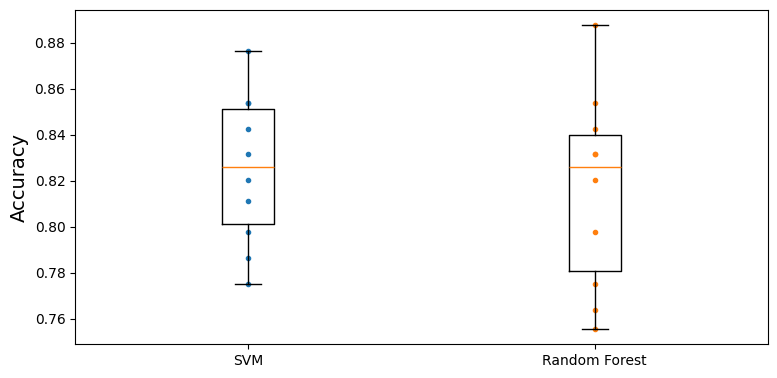

In [115]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy")
save_fig("random_forest_vs_svm_accuracy_box_plot")
plt.show()

The `RandomForestClassifier` got a very high score on one of the 10 folds, but overall it had a lower mean score, as well as a bigger spread, so it looks like the `SVC` is more likely to generalize well.

Tune the SVCs hyperparameters

Save the tuned parameter settings to the Kitfile.

Finally, let's export the selected model (`SVC`) in the joblib format as "model.joblib".

In [116]:
import joblib

artifact_filename = 'model.joblib'

# Save model artifact to local filesystem (doesn't persist)
model_path = Path() / MODEL_DIR_NAME / artifact_filename
joblib.dump(svm_clf, model_path)


['model/model.joblib']

And now we can update our Kitfile's **model** section.

In [117]:
# add the 'images' folder to the 'docs' section of the Kitfile
model_info = {
    "name": "titanic-survivability-predictor",
    "path": MODEL_DIR_NAME,
    "description": "Directory containing figures and graphs exported as image files.",
    "framework": "joblib",
    "license": "Apache-2.0",
    "version": "1.0"
}

kitfile["model"] = model_info

# save the updated Kitfile contents to disk
export_kitfile(kitfile)

# reload the Kitfile from disk and display the contents
# to make sure it was persisited correctly
kitfile = import_kitfile()
print_kitfile_contents(kitfile)

Kitfile Contents...

manifestVersion: '1.0'
package:
  name: Titanic-Survivability-Predictor
  version: 1.0.0
  description: A model attempting to predict passenger survivability of the Titanic
    Shipwreck
  authors:
  - Jozu
docs:
- path: README.md
  description: Important notes about the project.
- path: images
  description: Directory containing figures and graphs exported as image files.
code:
- path: requirements.txt
  description: Python packages required by this example.
  license: Apache-2.0
- path: titanic_survivability.ipynb
  description: Jupyter Notebook used to train, validate, optimize and export the model.
  license: Apache-2.0
datasets:
- name: training
  path: data/train.csv
  description: Data to be used for model training.
  license: Apache-2.0
- name: testing
  path: data/test.csv
  description: Data to be used for model testing.
  license: Apache-2.0
model:
  name: titanic-survivability-predictor
  path: model
  description: Directory containing figures and graph

Finally, we can pack and push our final ModelKit to Jozu Hub!

In [128]:
pack_and_push_modelkit("latest")

Log in successful
Configuration already exists in storage: sha256:3ea1b65ef9437634e22b8fe623b7cc51bd46ffbb43f3bfd4c310b8896d560aa6
Already saved model layer: sha256:b3281b26076d0c3d380ec41f80e05a0831a10dc20e01f0189bd3ff5c45607fda
Already saved code layer: sha256:9de9f1238dd7a623c617cbc14e7f5eada59d28085909e9cf57279ce0ebd6a5ee
Already saved code layer: sha256:81229edff8b9a8f440964584e9bd48eb223019567d6fc925c4388ae14425010b
Already saved dataset layer: sha256:8af74261fda984270cc30a58277f28c3435de603ba2722e160528a0fab6d1127
Already saved dataset layer: sha256:cbd1c99ae96851ca944aeda77e1e8338c00fd639b9cdcdbe42044ec99352cb79
Already saved docs layer: sha256:7e9ebe2161f1b1402ac99a54022f9ee4a426fcd9b16ce8c5a31c8d1164e2f1bf
Already saved docs layer: sha256:c76ddfda186525d402a2f0e419cbf55ccf926e608498d8871c04383ab7776fe6
Manifest already exists in storage: sha256:c1ba041fcaf0588b2e6094d1ef4e12bef3482ac84df5b37a5df29229f4e1128a
Model saved: sha256:c1ba041fcaf0588b2e6094d1ef4e12bef3482ac84df5b37a